# Setting up a RBFE network for a system with cofactors

This tutorial gives a step-by-step process to set up a relative binding free energy (RBFE) simulation campaign using OpenFE when dealing with cofactors.

**Note**: This notebook acts as a supplement to the original RBFE python tutorial, and should only be used as an example of how the code can be extended to deal with arbitrary spectator molecules.

In [1]:
%matplotlib inline
import openfe

## Loading the ligands

First we must load the chemical models between which we wish to calculate free energies.
In this example these are initially stored in a molfile (`.sdf`) containing multiple molecules.
This can be loaded using the `SDMolSupplier` class from rdkit and passed to openfe.

#### About the data

Here we are loading the positive ligands from the protein-ligand benchmark set's EG5 system. As charge corrections have yet to be fully implemented in OpenFE, we will stick to doing transformations without net charges for now.

**Note:** We add user charges to our input ligands by going through OpenFF molecules first. This avoids any issues with inconsistent partial charge assignment.

In [2]:
from rdkit import Chem
from openff.toolkit import Molecule

# Create a list of OpenFF molecules
offmols = [
    Molecule.from_rdkit(m)
    for m in Chem.SDMolSupplier("eg5_ligands_positive.sdf", removeHs=False)
]

# Assign partial charges via AM1BCC
for mol in offmols:
    mol.assign_partial_charges('am1bcc', use_conformers=mol.conformers)

# Now we convert them to SmallMoleculeComponent
ligands = [openfe.SmallMoleculeComponent.from_openff(mol) for mol in offmols]

/home/richard/miniconda3/envs/openfe_stable/lib/python3.11/site-packages/gufe/components/explicitmoleculecomponent.py:79: UserWarning: Partial charges have been provided, these will preferentially be used instead of generating new partial charges
  warnings.warn(wmsg)


## Creating the `LigandNetwork`

The first step is to create a `LigandNetwork`, which is a network with small molecules as nodes, and atom mappings, the description of how to alchemically mutate between the molecules, as its edges.

The pipeline for creating a `LigandNetwork` involves three components:

* **Atom Mapper**: Proposes potential atom mappings (descriptions of the alchemical change) for pairs of ligands. We will use the `LomapAtomMapper`.
* **Scorer**: Given an atom mapping, provides an estimate of the quality of that mapping (higher scores are better). We will use `default_lomap_scorer`.
* **Network Planner**: Creates the actual `LigandNetwork`; different network planners provide different strategies. We will create a minimal spanning network with the `generate_minimal_spanning_network` method.

Each of these components could be replaced by other options.

In [3]:
mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=False, threed=True)
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network

The exact call signature depends on the network planner: a minimal spanning network requires a score, whereas that is optional for a radial network (but a radial network needs the central ligand to be provided).

In [4]:
ligand_network = network_planner(
    ligands=ligands,
    mappers=mapper,
    scorer=scorer
)

 23%|##2       | 39/171 [00:01<00:05, 25.66it/s]

Now we can look at the overall structure of the `LigandNetwork`:

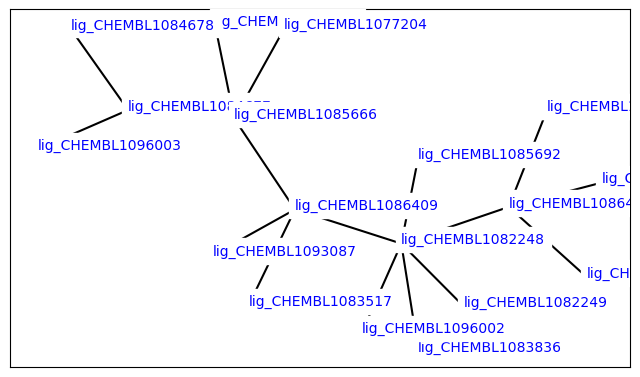

In [5]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

We can also inspect the individual atom mappings:

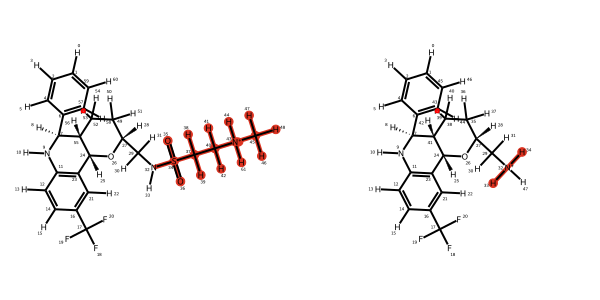

In [6]:
# get the first edge; it automatically displays in a Jupyter notebook
mapping = next(iter(ligand_network.edges))
mapping

To get the score for this mapping, we inspect its `annotations` attribute. Arbitrary annotations can be added when a mapping is created, although our network generator only includes the score.

In [7]:
# higher score is better
mapping.annotations

{'score': 0.49658530379140947}

We can also use the py3dmol openfe interface to visualise our mappings in 3D

In [8]:
from ipywidgets import interact, widgets
from openfe.utils.visualization_3D import view_mapping_3d

edges = list(ligand_network.edges)

def display_edge_3d(index):
    view = view_mapping_3d(edges[index], spheres=True, show_atomIDs=True)
    view.show()

In [9]:
# traverse through all views
interact(display_edge_3d, index=widgets.IntSlider(min=0, max=len(edges)-1, step=1));

interactive(children=(IntSlider(value=0, description='index', max=17), Output()), _dom_classes=('widget-intera…

You can output the ligand network to the same `graphml` format as we saw in the CLI tutorial with the following:

In [10]:
with open("ligand_network.graphml", mode='w') as f:
    f.write(ligand_network.to_graphml())

## Creating a single `Transformation`

The `LigandNetwork` only knows about the small molecules and the alchemical connections between them. It doesn't know anything about environment (e.g., solvent) or about the `Protocol` that will be used during the simulation.

That information in included in a `Transformation`. Each of these transformations corresponds to a single leg of the simulation campaign, so for each edge in the `LigandNetwork`, we will create two `Transformation`s: one for the complex and one for solvent.

In practice, this will be done for each edge of the `LigandNetwork` in a loop, but for illustrative purposes we'll dive into the details of creating a single transformation. In particular, we'll create the solvent leg for the pair of molecules we selecting for the mapping above.

### Creating `ChemicalSystem`s

OpenFE describes complex molecular systems as being composed of `Component`s. For example, we have `SmallMoleculeComponent` for each small molecule being perturbed in the `LigandNetwork`. We will also create a `SolventComponent` to describe the solvent, a `ProteinComponent` for our EG5 complex simulations, and an extra `SmallMoleculeCompoinent` for the ATP cofactor bound to EG5.

The `Component`s are joined in a `ChemicalSystem`, which describes all the particles in the simulation.

In [11]:
# defaults are water with NaCl at 0.15 M
solvent = openfe.SolventComponent()

In [12]:
# load in the EG5 protein
protein = openfe.ProteinComponent.from_pdb_file("./eg5_protein.pdb")

In [13]:
# load in the cofactor from eg5_cofactors.sdf, here we know that there is only one cofactor in the file
# We also go through OpenFF to assign partial charges
offmol = Molecule.from_rdkit(Chem.MolFromMolFile("eg5_cofactor.sdf", removeHs=False))
offmol.assign_partial_charges('am1bcc', use_conformers=offmol.conformers)
cofactor = openfe.SmallMoleculeComponent.from_openff(offmol)

/home/richard/miniconda3/envs/openfe_stable/lib/python3.11/site-packages/gufe/components/explicitmoleculecomponent.py:79: UserWarning: Partial charges have been provided, these will preferentially be used instead of generating new partial charges
  warnings.warn(wmsg)


In [14]:
# Note: if you had multiple cofactors you could add any additional cofactor
# as additional dictionary entries in both of the ChemicalSystem definitions
systemA = openfe.ChemicalSystem({
    'ligand': mapping.componentA,
    'solvent': solvent,
    'protein': protein,
    'cofactor': cofactor,
})
systemB = openfe.ChemicalSystem({
    'ligand': mapping.componentB,
    'solvent': solvent,
    'protein': protein,
    'cofactor': cofactor,
})

### Creating a `Protocol`

The actual simulation is performed by a `Protocol`. We'll use an OpenMM-based hybrid topology relative free energy `Protocol`.

In [15]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol

The easiest way to customize protocol settings is to start with the default settings, and modify them. Many settings carry units with them.

In [16]:
settings = RelativeHybridTopologyProtocol.default_settings()
print(settings.system_settings.nonbonded_method)  # display default value
print(settings.simulation_settings.production_length)

PME
5.0 nanosecond


We'll use the default settings for the protocol we'll use later, to match the behavior of the CLI.

In [17]:
default_settings = RelativeHybridTopologyProtocol.default_settings()
protocol = RelativeHybridTopologyProtocol(default_settings)

### Creating the `Transformation`

Once we have the mapping, the two `ChemicalSystem`s, and the `Protocol`, creating the `Transformation` is easy:

In [18]:
transformation = openfe.Transformation(
    systemA,
    systemB,
    protocol,
    mapping={'ligand': mapping},
)

To summarize, this `Transformation` contains:
- chemical models of both sides of the alchemical transformation in `systemA` and `systemB`
- the correspondence of items in these two sides in `mapping` 
- a description of the exact computational algorithm to use to perform the estimate in `protocol`

## Creating the `AlchemicalNetwork`

The `AlchemicalNetwork` contains all the information needed to run the entire campaign. It consists of a `Transformation` for each leg of the campaign. We'll loop over all the mappings, and then loop over the legs. In that inner loop, we'll make each transformation.

In [19]:
transformations = []
for mapping in ligand_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and protein created above
        sysA_dict = {'ligand': mapping.componentA,
                     'solvent': solvent}
        sysB_dict = {'ligand': mapping.componentB,
                     'solvent': solvent}
        
        if leg == 'complex':
            sysA_dict['protein'] = protein
            sysA_dict['cofactor'] = cofactor
            sysB_dict['protein'] = protein
            sysB_dict['cofactor'] = cofactor
        
        # we don't have to name objects, but it can make things (like filenames) more convenient
        sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_{leg}")
        sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_{leg}")
        
        prefix = "easy_rbfe_"  # prefix is only to exactly reproduce CLI
        
        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping={'ligand': mapping},
            protocol=protocol,  # use protocol created above
            name=f"{prefix}{sysA.name}_{sysB.name}"
        )
        transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)

## Writing the `AlchemicalNetwork` to disk

We'll write out each transformation to disk, so that they can be run independently using the `openfe quickrun` command:

In [20]:
import pathlib
# first we create the directory
transformation_dir = pathlib.Path("transformations")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.dump(transformation_dir / f"{transformation.name}.json")

In [21]:
!ls transformations/

easy_rbfe_lig_CHEMBL1082248_complex_lig_CHEMBL1082249_complex.json
easy_rbfe_lig_CHEMBL1082248_complex_lig_CHEMBL1096002_complex.json
easy_rbfe_lig_CHEMBL1082248_solvent_lig_CHEMBL1082249_solvent.json
easy_rbfe_lig_CHEMBL1082248_solvent_lig_CHEMBL1096002_solvent.json
easy_rbfe_lig_CHEMBL1083517_complex_lig_CHEMBL1086409_complex.json
easy_rbfe_lig_CHEMBL1083517_solvent_lig_CHEMBL1086409_solvent.json
easy_rbfe_lig_CHEMBL1083836_complex_lig_CHEMBL1082248_complex.json
easy_rbfe_lig_CHEMBL1083836_solvent_lig_CHEMBL1082248_solvent.json
easy_rbfe_lig_CHEMBL1084143_complex_lig_CHEMBL1086410_complex.json
easy_rbfe_lig_CHEMBL1084143_solvent_lig_CHEMBL1086410_solvent.json
easy_rbfe_lig_CHEMBL1084677_complex_lig_CHEMBL1084678_complex.json
easy_rbfe_lig_CHEMBL1084677_complex_lig_CHEMBL1085666_complex.json
easy_rbfe_lig_CHEMBL1084677_complex_lig_CHEMBL1096003_complex.json
easy_rbfe_lig_CHEMBL1084677_solvent_lig_CHEMBL1084678_solvent.json
easy_rbfe_lig_CHEMBL1084677_solvent_lig_CHEMBL1085666_solvent.

Each of these individual `.json` files contains a `Transformation`, which contains all the information to run the calculation.  These could be farmed out as individual jobs on a HPC cluster. These files are identical to what were created in setup stage of the CLI tutorial; for details on running them, follow from the section on running simulations in the CLI tutorial